In [1]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
%%time
trans = pd.read_parquet('./hack_data/transactions.parquet', engine='pyarrow', use_threads=True)

CPU times: user 24.4 s, sys: 35.7 s, total: 1min
Wall time: 1min 8s


In [3]:
rows_number =  10 ** 7
trans_short = trans.iloc[:rows_number]

trans_short = trans_short[['plant', 'client_id', 'chq_date', 'sales_count', 'sales_sum', 'material']]

le = preprocessing.LabelEncoder()
trans_short['client_id'] = le.fit_transform(trans_short['client_id'])
trans_short['product_id'] = le.fit_transform(trans_short['material'])
trans_short['shop_id'] = le.fit_transform(trans_short['plant'])
trans_short = trans_short.drop(columns=['material', 'plant'])

del trans

In [19]:
def GMV_calculation(data, shop_id, current_date, N_prev_months=5):
    shop_df = data[data['shop_id'] == shop_id]
    shop_df['date'] = shop_df['chq_date'].apply(lambda x: datetime(x.year, x.month, 1, 0, 0))
    shop_df = shop_df[['date', 'sales_sum']]
    shop_df = shop_df.groupby(['date'], as_index=False).sum()

    shop_df['months_delta'] = shop_df['date'].apply(lambda x: 12 * (current_date.year - x.year) +\
                                                          (current_date.month - x.month))


    shop_df = shop_df[shop_df['months_delta'] >= 1]
    shop_df = shop_df.sort_values(by=['months_delta'], ascending=False)
    shop_df['month_year'] = shop_df['date'].apply(lambda x: str(x.month) + '.' + str(x.year))

    month_year_lst = shop_df['month_year'].values[-N_prev_months:]
    sales_sum_lst = shop_df['sales_sum'].values[-N_prev_months:]
    return month_year_lst, sales_sum_lst


shop_id = 109
current_date = datetime(2018, 1, 20)

month_year_lst, sales_sum_lst = GMV_calculation(trans_short, shop_id, current_date)

### to csv

In [90]:
df = pd.DataFrame(data=np.array([month_year_lst, sales_sum_lst]).T,
                  columns=['month_year', 'GMV'])
df.to_csv('./for_excel/gmv_shop_id_{}.csv'.format(shop_id), index=False)

### visualization

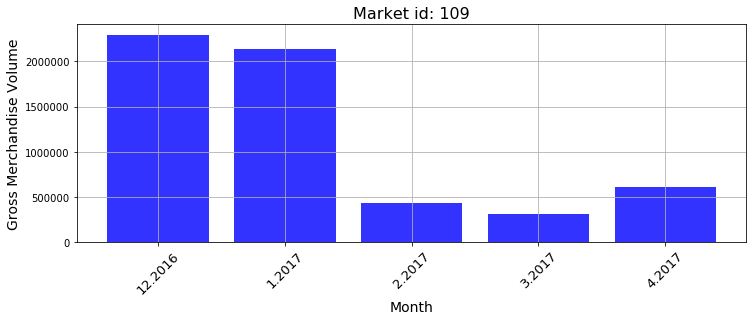

In [20]:
plt.figure(figsize=(12,4))

plt.bar(np.arange(len(month_year_lst)), sales_sum_lst, color='blue', alpha=0.8)

plt.title('Market id: {}'.format(shop_id), fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Gross Merchandise Volume', fontsize=14)
plt.xticks(np.arange(len(month_year_lst)), month_year_lst, rotation=45, fontsize=13)

plt.grid()
plt.savefig('./pics/GMV_shop_id_{}.pdf'.format(shop_id))
plt.show()